In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Robotkesif:
    #constructor
    def __init__(self,size=5):
        #size ortam boyutu
        self.size=size # default olarak 5*5

        #state space = observation space = ajanın hareket edebileceği bölgeler,stateler
        self.state_space = size*size # default 25

        #action space = eylem alanı
        self.action_space = 4 # aşağı,yukarı,sağ,sol

        #başlangıç state
        self.start_state = (0,0)

        #hedef kaynak noktaları
        self.goal_states = [(4,4),(1,3)]

        #engeller = cealar veya kısıtlar
        self.obstacles = [(2,2),(3,1)]

        #ortamı sıfılarla doldurma
        self.lab = np.zeros((size,size))

    #reset function: ortamı sıfırlamak,ilk haline getirmek  
    def reset(self):
        self.robot_position = self.start_state #robotu başlangıç pozisyonuna ayarladık
        return self.robot_position #robotun mevcut koordinatlarını alalım

    #step function:ortam içerinde hareket etmek,action sonunda new state ve reward güncelle
    def step(self,action):
        x,y = self.robot_position #robotun mevcut koordinatları 

        if action == 0: #yukarı hareket
            x = max(0, x - 1) #sınırları kontrol et
        elif action == 1: #aşağı hareket
            x = min(self.size - 1, x+1)
        elif action == 2: #sola hareket
            y = max(0, y - 1)
        elif action == 3: #sağa haereket
            y = min(self.size - 1, y + 1)

        self.robot_position = (x,y)

        #ödül koşulları
        if self.robot_position in self.goal_states: #hedefe ulaşıldı
            return self.robot_position,10,True
        elif self.robot_position in self.obstacles: #engelle karşlaştıysa
            return self.robot_position,-5,True
        else: #boş alanda hareket ediliyorsa
            return self.robot_position,0,False
             

In [3]:
#Q learning agent oluşturma

#class QlearningAgent Class
class QLearningAgent:
    
    #initizalizer
    def __init__(self,env):
        
        self.env=env # ortam
        self.q_table =  np.zeros((env.state_space,env.action_space)) #25*4
        self.alpha = 0.1 #learning rate
        self.gamma = 0.99 #gelecek ödüllerin indirgeme faktörü
        self.epsilon = 1.0 #keşif rate
        self.epsilon_decay = 0.995 #epsilon değerinin azalması için faktör
        self.min_epsilon = 0.01 #epsilon alt sınır

    #durum indexi hesaplama
    def get_state_index(self,state):
        return state[0] * self.env.size + state[1] # durumun indexini hesapla

    #choose action
    def choose_action(self,state):
        if random.uniform(0,1) < self.epsilon: #epsilon greedy stratejisi
            return random.randint(0,self.env.action_space - 1) #keşif için rastgele eylemi seç
        else:
            state_idx = self.get_state_index(state) #mevcut durumun indexini al
            return np.argmax(self.q_table[state_idx]) #en yüksek q değerine sahip eylemi seç
    
    #learning
    def learn(self, state,action, reward, new_state): 
        state_idx = self.get_state_index(state) #mevcut durumun indexini al
        next_state_idx = self.get_state_index(new_state) #sonraki durumun indexini al

        #q değerini güncelleme
        best_next_action = np.argmax(self.q_table[next_state_idx]) #en iyi sonraki eylemi bulma
        td_target = reward + self.gamma * self.q_table[next_state_idx][best_next_action] # hedef q değeri
        td_delta = td_target - self.q_table[state_idx][action] #hata hesabı
        self.q_table[state_idx][action] += self.alpha * td_delta #q tablosunu güncelleme

In [4]:
#training and testing

env = Robotkesif() #robot keşif ortamı oluştur
agent = QLearningAgent(env) #q learning agent
episodes = 1000 #episode sayısı tanımla
rewards_per_episodes = [] #her bir episode için gerekli ödüllerin saklanması

for episode in range(episodes): #her bir episode için bir döngü başlatma
    state = env.reset() #ortamı sıfırla
    total_reward = 0 #toplam ödülü sıfırla
    done = False #episode tamamlandı durumu sıfırla
    
    while not done: #episode tammalnadıkça while döngüsü devam etsin
        action = agent.choose_action(state) # bir eylem seçelim
        next_state, reward, done = env.step(action) #ortam içiresinde eylemi uygula yeni bir adımat
        agent.learn(state,action,reward,next_state) #learning işlemini gerçekletir
        state = next_state #state güncellesmei yap
        total_reward += reward #toplam ödülü güncelle

    agent.position = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay) #epsilonu güncelle
    rewards_per_episodes.append(total_reward) #episode sonundaki toplam ödülü sakla
    

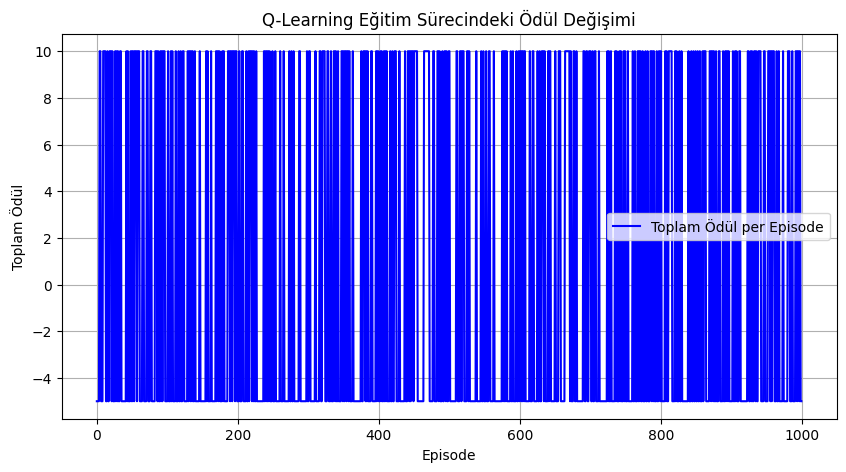

In [5]:
# Ödüllerin episode bazında değişimini görselleştir
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episodes, label="Toplam Ödül per Episode", color='b')
plt.xlabel("Episode")
plt.ylabel("Toplam Ödül")
plt.title("Q-Learning Eğitim Sürecindeki Ödül Değişimi")
plt.legend()
plt.grid()

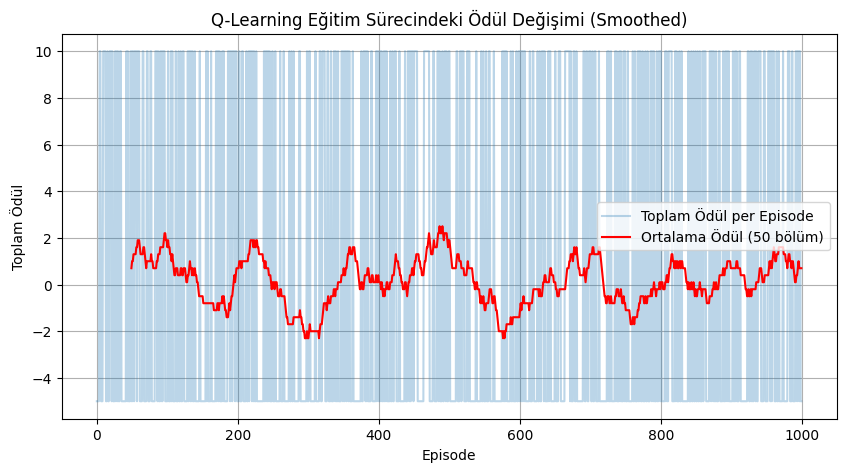

In [6]:
import pandas as pd
window_size = 50  # Ortalama için pencere boyutu
rewards_smoothed = pd.Series(rewards_per_episodes).rolling(window_size).mean()

plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episodes, label="Toplam Ödül per Episode", alpha=0.3)
plt.plot(rewards_smoothed, label=f"Ortalama Ödül ({window_size} bölüm)", color='r')
plt.xlabel("Episode")
plt.ylabel("Toplam Ödül")
plt.title("Q-Learning Eğitim Sürecindeki Ödül Değişimi (Smoothed)")
plt.legend()
plt.grid()